In [170]:
include("meshgenerator.jl")
using LaTeXStrings

In [94]:
function p2mesh(p, t)
    # copy t2 such that it can hold 6 points pr element
    t2 = zeros(Int64, size(t, 1), 6)
    t2[:, 1:3] = t
    p2 = copy(p)
    e2 = boundary_nodes(t)

    counter = ones(Int64, size(t, 1)) * 3  # counts found points pr element
    num_points = size(p, 1)  # number of points in p

    edges, bnidx, emap = all_edges(t)
    for edge in emap  # for every edge
        if edge != 0  # if edge has not already been done
            # Find midpoint and add to p2
            q1 = p[edges[edge, 1], :]
            q2 = p[edges[edge, 2], :]
            new = q1 + 0.5(q2 - q1)
            p2 = [p2; new']
            num_points += 1

            # find every occurance of edge in emap
            in_triangles = findall(x->x==edge, emap)
            if length(in_triangles) == 1
                e2 = [e2; num_points]
            end
            for triangle in in_triangles  # loop over occurances
                emap[triangle] = 0  # mark edge as done
                T = triangle[1]  # find corresponding triangle
                counter[T] += 1  # increment triangle counter
                t2[T, counter[T]] = num_points  # insert last point (new) into triangulation
            end                
        end
    end
    return p2, t2, e2
end


p2mesh (generic function with 1 method)

In [121]:
function test_case()
    p = [0. 0; 1 0; 0 1; 1 1; .5 .5]
    t = [1 2 5; 5 4 3; 1 3 5]
    e = boundary_nodes(t)
    p2, t2, e2 = p2mesh(p, t)
    display(p)
    display(t)
    display(e)
    display(p2)
    display(t2)
    display(e2)
end
# test_case()

test_case (generic function with 1 method)

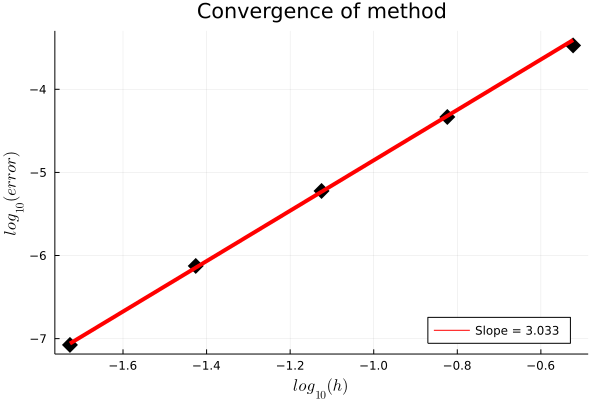

In [175]:
function convergence_fempoi2()
    hmax = 0.3
    nrefmax = 5
    pv = [0 0; 1 0; 1 1; 0 1; 0 0]
    num_pts = size(pmesh(pv, hmax, 0)[1], 1)

    exact_sol = fempoi2(p2mesh(pmesh(pv, hmax, nrefmax)[1:2]...)...)

    errors = zeros(nrefmax)
    hs = zeros(nrefmax)
    for nref = nrefmax-1:-1:0
        p, t, e = pmesh(pv, hmax, nref)
        p2, t2, e2 = p2mesh(p, t)
        sol = fempoi2(p2, t2, e2)

        diff = sol[1:num_pts] - exact_sol[1:num_pts]
        errors[nref + 1] = maximum(abs.(diff))
        hs[nref+1] = hmax / (2^nref)
    end
    hs = log10.(hs)
    errors = log10.(errors)
    X = zeros(length(hs)-1, 2)
    X[:, 1] .= hs[2:end]
    X[:, 2] .= 1
    slope, inter = X \ errors[2:end]
    plot(hs, errors, c="black", markershapes=:diamond, st=:scatter, markersize=8, label=false)
    plot!(hs, inter .+ slope .* hs, c="red", lw=4, label="Slope = $(round(slope, digits=3))")
    P = plot!(title="Convergence of method", xaxis=L"log_{10}(h)", yaxis=L"log_{10}(error)", legend=:bottomright)
    savefig("figs/fempoi2_convergence.pdf")
    display(P)

end
convergence_fempoi2()

In [144]:
function fempoi2(p, t, e)
    n = size(p, 1)
    A = []
    b = zeros(n)
    for k = 1:size(t, 1)
        sA, sb = get_stamp(p, t[k, :])
        for i = 1:6, j=1:6
            push!(A, (t[k, i], t[k, j], sA[i, j]))
        end
        b[t[k, :]] += sb
    end
    A = sparse((x -> x[1]).(A), (x -> x[2]).(A), (x -> x[3]).(A), n, n)

    # Imposing homogeneous Dirichlet conditions
    for edge in e
        A[edge, :] .= 0
        A[:, edge] .= 0
        A[edge, edge] = 1
        b[edge] = 0
    end
    A = sparse(A) * 1.0
    # Solve PDE
    A \ b
end

fempoi2 (generic function with 1 method)

In [143]:
function get_stamp(p, t)
    _area = area(p[t[1:3], :]) / 2

    V = zeros(6, 6)
    V[:, 1] .= 1
    V[:, 2] = p[t, 1]
    V[:, 3] = p[t, 2]
    V[:, 4] = p[t, 1].^2
    V[:, 5] = p[t, 2].^2
    V[:, 6] = p[t, 1] .* p[t, 2]
    C = inv(V)

    A = zeros(6, 6)
    b = zeros(6)
    for i = 1:6
        A[i, i] = quad_A(p[t[1:3], :], C[:, i], C[:, i])
        b[i] = quad_b(p[t[1:3], :], C[:, i])
        for j = 1:i-1
            A[i, j] = quad_A(p[t[1:3], :], C[:, i], C[:, j])
            A[j, i] = A[i, j]
        end
    end
    (A, b) .* _area
end
# get_stamp(p2, t2[1, :])

get_stamp (generic function with 1 method)

In [142]:
delta(i, j) = Int64(i == j) / 2
xi(X, i) = sum([X[j]/6 + delta(i, j) * X[j] for j = 1:3])
function quad_A(X, Ci, Cj)
    s = 0
    for i = 1:3
        x = xi(X[:, 1], i)
        y = xi(X[:, 2], i)
        s += (Ci[2] + 2Ci[4]*x + Ci[6]*y) * (Cj[2] + 2Cj[4]*x + Cj[6]*y) / 3
        s += (Ci[3] + 2Ci[5]*y + Ci[6]*x) * (Cj[3] + 2Cj[5]*y + Cj[6]*x) / 3
    end
    return s
end

function quad_b(X, Ci)
    a, b, c, d, e, f = Ci
    s = 0
    for i = 1:3
        x = xi(X[:, 1], i)
        y = xi(X[:, 2], i)
        s += a + b*x + c*y + d*x^2 + e*y^2 + f*x*y
    end
    return s
end

quad_b (generic function with 1 method)